# 1. 加载数据, 并查看数据分布

In [17]:
from collections import defaultdict
from pathlib import Path
def load_data(path_dir: Path):
    data = defaultdict(list)
    for image_file in path_dir.rglob("*"):
        if image_file.is_file():
            class_info = image_file.name.split(".")[0]
            data[class_info].append(image_file)

    print(f"读取数据完成: 共有 {len(data)} 个类别")
    print("每类数据有如下统计:")
    for k, v in data.items():
        print(f"{k}: {len(v)}")
    return data

path_dir = Path("./train")
dataset = load_data(path_dir)

读取数据完成: 共有 2 个类别
每类数据有如下统计:
cat: 12500
dog: 12500


# 2. 查看数据分布情况

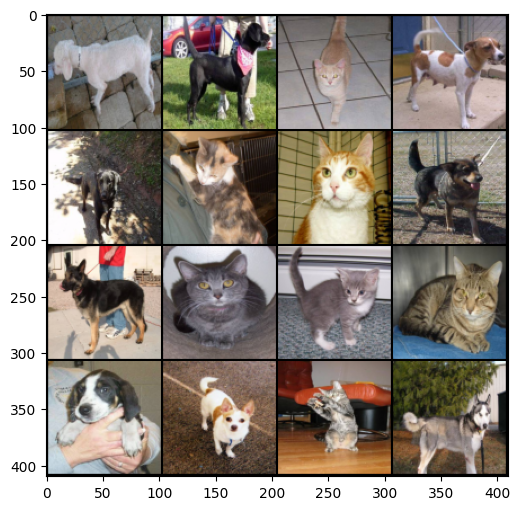

In [19]:
import random
from torchvision.utils import make_grid
from torchvision import transforms
from skimage import io, transform
import matplotlib.pyplot as plt

def show_pic(img_path_list):
    img_list = []
    for img_path in img_path_list:
        # 使用 skimage 读取图片
        img = io.imread(img_path)
        # 裁剪图片到指定尺寸
        resized_img = transform.resize(img, (100, 100), mode="reflect")
        # 转换图片为张量
        img_tensor = transforms.ToTensor()(resized_img)
        img_list.append(img_tensor)

    # 将图片合并成每行四张的大图并显示
    img_show = make_grid(img_list, nrow=4, normalize=True)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_show.permute(1, 2, 0).numpy())


all_path = []
label = []
for k, v in dataset.items():
    all_path.extend(v)
    label.extend([k] * len(v))
img_path_list = random.sample(all_path, 16)
show_pic(img_path_list)

# 3. 数据集划分

In [20]:
# 数据集划分
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 定义标签为0, 1
le = LabelEncoder()
le.fit(["cat", "dog"])
data_label = le.transform(label)

train_path, val_path, train_label, val_label = train_test_split(
    all_path, data_label, test_size=0.2
)

len(train_path), len(val_path), len(train_label), len(val_label)

(20000, 5000, 20000, 5000)

# 4. 数据增广

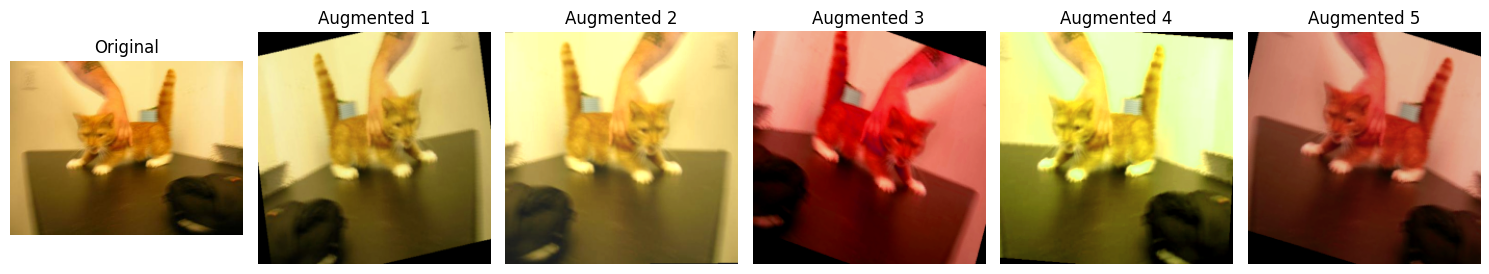

In [21]:
"""
数据增广
"""
from PIL import Image

# 定义数据增强的Transform
normalize_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),                   # 随机水平翻转
    transforms.RandomRotation(degrees=30),                     # 随机旋转±30度
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # 随机缩放裁剪
    transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                           saturation=0.2, hue=0.1),          # 颜色抖动
    transforms.RandomGrayscale(p=0.1),                         # 随机灰度化
    transforms.ToTensor(),                                     # 转换为Tensor
    transforms.Normalize([0.485, 0.456, 0.406],                # 标准化（使用ImageNet的均值和标准差）
                         [0.229, 0.224, 0.225])
])

def imshow_tensor(img_tensor, ax):
    """
    将Tensor图像转换为可视化图像并显示在指定的Matplotlib轴上。
    
    Args:
        img_tensor (Tensor): 标准化后的图像Tensor。
        ax (matplotlib.axes.Axes): Matplotlib的轴对象。
    """
    # 定义反标准化Transform，以便可视化
    un_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = un_normalize(img_tensor).numpy().transpose((1, 2, 0))
    img = img.clip(0, 1)
    ax.imshow(img)
    ax.axis('off')

def visualize_augmentations(image_path, transform, augmentation_times=5):
    """
    可视化一张图像经过多次数据增强后的效果。
    
    Args:
        image_path (str): 原始图像的路径。
        transform (torchvision.transforms.Compose): 数据增强的Transform。
        augmentation_times (int, optional): 要生成的增强图像数量。
    """
    # 打开并转换图像为RGB
    original_image = Image.open(image_path).convert('RGB')
    
    # 创建一个Matplotlib图形
    fig, axes = plt.subplots(1, augmentation_times + 1, figsize=(15, 5))
    
    # 显示原始图像
    axes[0].imshow(original_image)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # 生成并显示增强后的图像
    for i in range(augmentation_times):
        augmented_image = transform(original_image)
        imshow_tensor(augmented_image, axes[i + 1])
        axes[i + 1].set_title(f"Augmented {i+1}")
    
    plt.tight_layout()
    plt.show()
    
image_path = "../train/cat.0.jpg"
visualize_augmentations(image_path, normalize_transforms)

# 构建pytorch可读取的数据类

In [22]:
# 加载数据
from torch.utils.data import Dataset

class DogCatDataset(Dataset):
    def __init__(self, data_path, data_label, transform=None):
        """
        - data_path (string): 图片路径
        - data_label (string): 图片标签
        - transform (callable, optional): 作用在每个样本上的预处理函数
        """
        self.data_path = data_path
        self.data_label = data_label
        self.transform = transform

    def __len__(self):
        """ 返回数据集的大小 """
        return len(self.data_path)

    def __getitem__(self, idx):
        img_path = self.data_path[idx]
        image = io.imread(img_path)
        label = self.data_label[idx]

        # 如果有，则对数据预处理
        if self.transform:
            image = self.transform(image)

        return image, label

# pytorch加载数据集

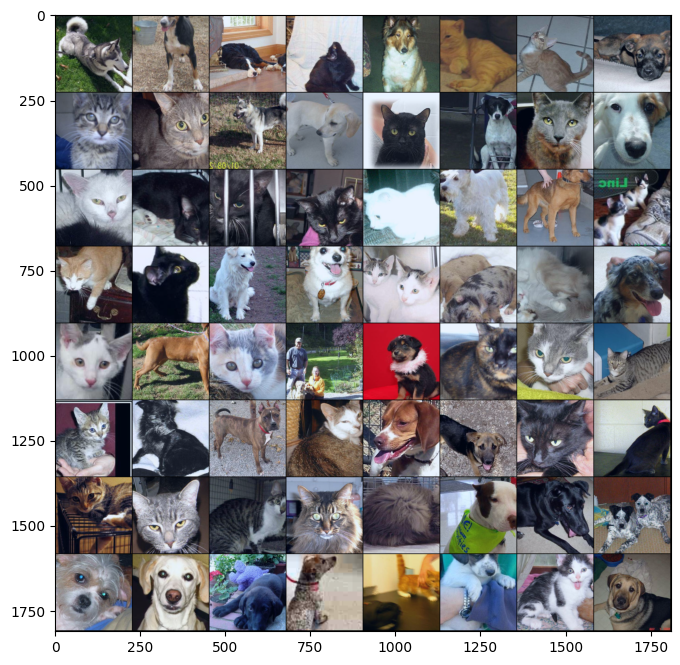

In [23]:
import torch.utils.data
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),  # 水平镜像
            transforms.ToTensor(),
            transforms.Normalize(
                # 用平均值和标准偏差归一化张量图像
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),  # input = (input - mean) / std
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),  # 测试只需要从中间裁剪
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
}
# 初始化训练数据集
train_dataset = DogCatDataset(train_path, train_label, data_transforms["train"])
# 初始化测试数据集
val_dataset = DogCatDataset(val_path, val_label, data_transforms["val"])

# 训练数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# 验证数据加载器
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# 验证是否加载成功
for batch_index, sample_batch in enumerate(train_loader):
    images, labels = sample_batch
    sample_images = make_grid(images, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(sample_images.permute(1, 2, 0).numpy())
    break

# 模型加载

In [24]:
# 导入resnet,进行猫狗二分类训练
from torchvision import models
import torchvision
# 加载预训练的 ResNet18 模型
# 对于 torchvision >= 0.13
def get_model():
    if torchvision.__version__ >= "0.13":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    else:
        # 对于 torchvision <= 0.12
        model = models.resnet18(pretrained=True)
        # alexnet = models.alexnet(pretrained=True)
        # vgg16 = models.vgg16(pretrained=True)
        
    # print(model)

    # 将所有模型输出为二分类
    num_features = model.fc.in_features # 获取低级特征维度
    # print(num_features) # 512最后一个fc层的特征维度
    model.fc = torch.nn.Linear(num_features,2) # 本文使用的数据为两个类别，所以设置为2

    # 模型冻结前面的层
    for param in model.layer1.parameters():
        param.requires_grad = False
    for param in model.layer2.parameters():
        param.requires_grad = False
    return model

# 加载本地预训练模型
# model.load_state_dict(best_model_wts)

# 使用 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 早停策略

In [25]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        # 初始化 EarlyStopping 类
        # 参数:
        # patience: 容忍的最大连续不改进次数，达到此次数将触发早停 (默认值为 5)
        # verbose: 是否输出详细信息 (默认值为 False)
        # delta: 最小改进值，只有当损失减少超过 delta 时才认为是改进 (默认值为 0)
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0  # 用于记录连续不改进的次数
        self.best_loss = float('inf')  # 初始时设置最优损失为正无穷
        self.early_stop = False  # 标志位，用于表示是否应触发早停

    def __call__(self, val_loss):
        # 检查当前验证损失是否比最佳损失低
        if val_loss < self.best_loss - self.delta:
            # 如果改进超过 delta，则更新最佳损失
            self.best_loss = val_loss
            self.counter = 0  # 重置计数器
            if self.verbose:
                print(f'Validation loss decreased to {val_loss:.4f}. Resetting counter.')
        else:
            # 如果没有改进，增加计数器
            self.counter += 1
            if self.verbose:
                print(f'No improvement in validation loss for {self.counter} consecutive epochs.')
            # 如果计数器达到容忍值 patience，则触发早停
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print('Early stopping triggered.')

# 数据可视化

In [26]:
from torch.utils.tensorboard import SummaryWriter

def visualize(save_path="'./pytorch_tb'"): 
    # 1. 可视化模型结构
    writer = SummaryWriter(save_path)
    input_tensor = torch.rand(1, 3, 224, 224).to(device)
    writer.add_graph(model, input_to_model = input_tensor)
    writer.close()

    # 2. 可视化数据集
    images, labels = next(iter(train_loader))
    # 仅查看一张图片
    writer.add_image('images[0]', images[0])
    writer.close()
    
    # 将多张图片拼接成一张图片，中间用黑色网格分割
    # create grid of images
    img_grid = torchvision.utils.make_grid(images)
    writer.add_image('image_grid', img_grid)
    writer.close()
    
    # 将多张图片直接写入
    writer.add_images("images",images,global_step = 0)
    writer.close()

# 模型训练

In [27]:
import torch
import copy
from tqdm import tqdm

def train_one_epoch(model, dataloader, criterion, optimizer, is_training):
    running_loss, running_acc = 0.0, 0  # 当前阶段的损失和正确预测数
    # 启用或禁用梯度计算
    with torch.set_grad_enabled(is_training):
        # 使用 tqdm 创建进度条
        pbar = tqdm(enumerate(dataloader), total=len(dataloader))
        for _, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.int64)  # 数据转移到设备
            outputs = model(inputs)  # 前向传播
            loss = criterion(outputs, labels)  # 计算损失

            if is_training:
                optimizer.zero_grad()  # 清空梯度
                loss.backward()  # 反向传播
                optimizer.step()  # 更新参数

            # 计算预测结果
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)  # 累加损失
            running_acc += (preds == labels.data).sum().item()  # 累加正确预测数

            # 更新进度条
            pbar.update(1)
            
    return running_loss, running_acc

def train_model(model, criterion, optimizer, num_epochs=25, patience=10, lr_decay_factor=0.1, lr_step_size=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc, best_loss = 0.0, float('inf')

    # 学习率调度器
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=lr_decay_factor,
                                                           patience=lr_step_size)

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}\n" + '-' * 10)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()  # 设置模型模式
            dataloader = train_loader if phase == 'train' else val_loader  # 选择数据加载器

            if phase == 'val':
                with torch.no_grad():  # 在验证阶段禁用梯度计算
                    running_loss, running_acc = train_one_epoch(model, dataloader, criterion, optimizer, False)
            else:
                running_loss, running_acc = train_one_epoch(model, dataloader, criterion, optimizer, True)

            epoch_loss, epoch_acc = running_loss / len(dataloader.dataset), running_acc / len(dataloader.dataset)
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # 记录损失和准确率
            writer.add_scalar(f'{phase}_loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}_accuracy', epoch_acc, epoch)
            
            if phase == 'val':
                scheduler.step(epoch_loss)
                early_stopping(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss, best_acc = epoch_loss, epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    print(f"Best validation Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

# 模型加载和评估

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, criterion):
    model.eval()  # 将模型设置为评估模式
    all_preds, all_labels = [], []
    incorrect_samples = []  # 存储错误预测的样本
    running_loss = 0.0

    # 定义反归一化
    mean = [0.485, 0.456, 0.406]  # 替换为您的实际均值
    std = [0.229, 0.224, 0.225]   # 替换为您的实际标准差
    inverse_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )
    
    with torch.no_grad():  # 禁用梯度计算
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device, torch.int64)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().numpy()
            labels = labels.cpu().numpy()
            all_preds.extend(preds) # 将预测结果转换为 NumPy 数组
            all_labels.extend(labels) # 将预测结果转换为 NumPy 数组
        
            # 记录错误预测的样本
            for pred, label, input in zip(preds, labels, inputs):
                if pred != label:
                    incorrect_samples.append((input.cpu(), pred, label))
 
    # 计算评价指标
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Test Loss: {running_loss / len(test_loader):.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # 使用SummaryWriter可视化分类错误样本
    writer = SummaryWriter('./runs')
    for input, pred, label in incorrect_samples[:10]:  # 限制为前10个样本以避免过多图像
        # 应用反归一化
        input = inverse_normalize(input)
        # 确保数据在 [0, 1] 范围内
        input = torch.clamp(input, 0, 1)
        
        fig, ax = plt.subplots()
        # 转换为 (H, W, C) 并转换为 NumPy 数组
        img = input.permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(f"Pred: {pred}, True: {label}")
        writer.add_figure('Incorrect Samples', fig, global_step=0)
    writer.close()

def load_weight_model(model=None):
    # 判断模型是否存在
    if not model:
        model = get_model()
        model.to(device)
    if Path('model.pth').exists():
        model.load_state_dict(torch.load('model.pth', weights_only=True))
        print("载入现有模型: model.pth")
    else:
        # 不存在现有模型, 执行模型训练
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        model = train_model(model, criterion, optimizer, num_epochs=25, 
                            patience=5, lr_decay_factor=0.1, lr_step_size=10,)

        # 保存模型
        torch.save(model.state_dict(), 'model.pth')
    return model

# 调用函数进行评估
model = load_weight_model(model)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
evaluate_model(model, test_loader, criterion)

载入现有模型: model.pth


Testing: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Test Loss: 1.6310
Accuracy: 0.9900
Precision: 0.9900
Recall: 0.9899
F1 Score: 0.9900


# 绘制T-sne

In [ ]:
import torch.nn as nn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def paint_tSNE(features_2d: np.ndarray, labels: np.ndarray):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    
    # 获取图例元素
    handles, _ = scatter.legend_elements()
    legend_labels = np.unique(labels)
    
    # 确保 legend_labels 是一个列表或一维数组
    legend_labels = [str(label) for label in legend_labels]
    
    plt.legend(handles=handles, labels=legend_labels, title="Classes")
    plt.title('t-SNE of ResNet-18 Features')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.show()

# 去掉最后的全连接层
model = load_weight_model()
model = nn.Sequential(*list(model.children())[:-1])
model.eval()  # 将模型设置为评估模式

test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# 提取特征
features, labels = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        outputs = outputs.view(outputs.size(0), -1)  # 展平
        features.append(outputs)
        labels.append(targets)
features,labels = torch.cat(features), torch.cat(labels) # 将特征和标签合并为单个数组

# t-SNE降维
tsne = TSNE(n_components=2, random_state=0) # 实例化t-sne对象
features_2d = tsne.fit_transform(features.cpu())

paint_tSNE(features_2d, labels)


# 绘制中间层tsne

In [ ]:
def assign_layer(layer_name='layer4'):
    # 选择要提取的中间层
    layer_name = 'layer4'  # 例如选择 layer4 的输出

    # 创建一个钩子来提取中间层的输出
    features = []

    # 定义钩子函数，用于在前向传播时提取中间层的输出
    def hook(module, input, output):
        # 将输出从计算图中分离，并转换为 numpy 数组，存储在 features 列表中
        features.append(output.detach().cpu().numpy())

    model = load_weight_model()
    layer = dict([*model.named_modules()])[layer_name]  # 获取模型中指定名称的层
    layer.register_forward_hook(hook)  # 注册前向钩子到指定层
    model.eval()

    # 提取特征
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            model(images)
            all_labels.extend(labels.numpy())

    # 将特征转换为2D
    features = np.concatenate(features, axis=0)  # 将提取的特征从列表中合并为一个 numpy 数组
    features = features.reshape(features.shape[0], -1)  # 将特征展平为二维数组，每行代表一个样本

    # 使用 T-SNE 进行降维
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)  # 使用 T-SNE 进行降维

    # 确保 labels 的长度与 features_2d 匹配
    all_labels = np.array(all_labels[:features_2d.shape[0]])

    paint_tSNE(features_2d, all_labels)

assign_layer()